In [60]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [61]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [62]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "preprocessed_data",
    shuffle=True,
    batch_size=BATCH_SIZE
    )

Found 3694 files belonging to 5 classes.


In [63]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot_rm_au',
 'Pepper__bell___healthy_rm_au',
 'Potato___Early_blight_rm_au',
 'Potato___Late_blight_rm_au',
 'Potato___healthy_rm_au']

In [64]:
len(dataset)

116

In [65]:
for image_batch, lable_batch in dataset.take(1):
    print(image_batch.shape)
    print(lable_batch.numpy())
    

(32, 256, 256, 3)
[0 0 1 2 1 1 2 1 0 1 1 0 1 1 4 3 1 2 2 4 2 2 1 2 2 0 1 2 1 2 0 1]


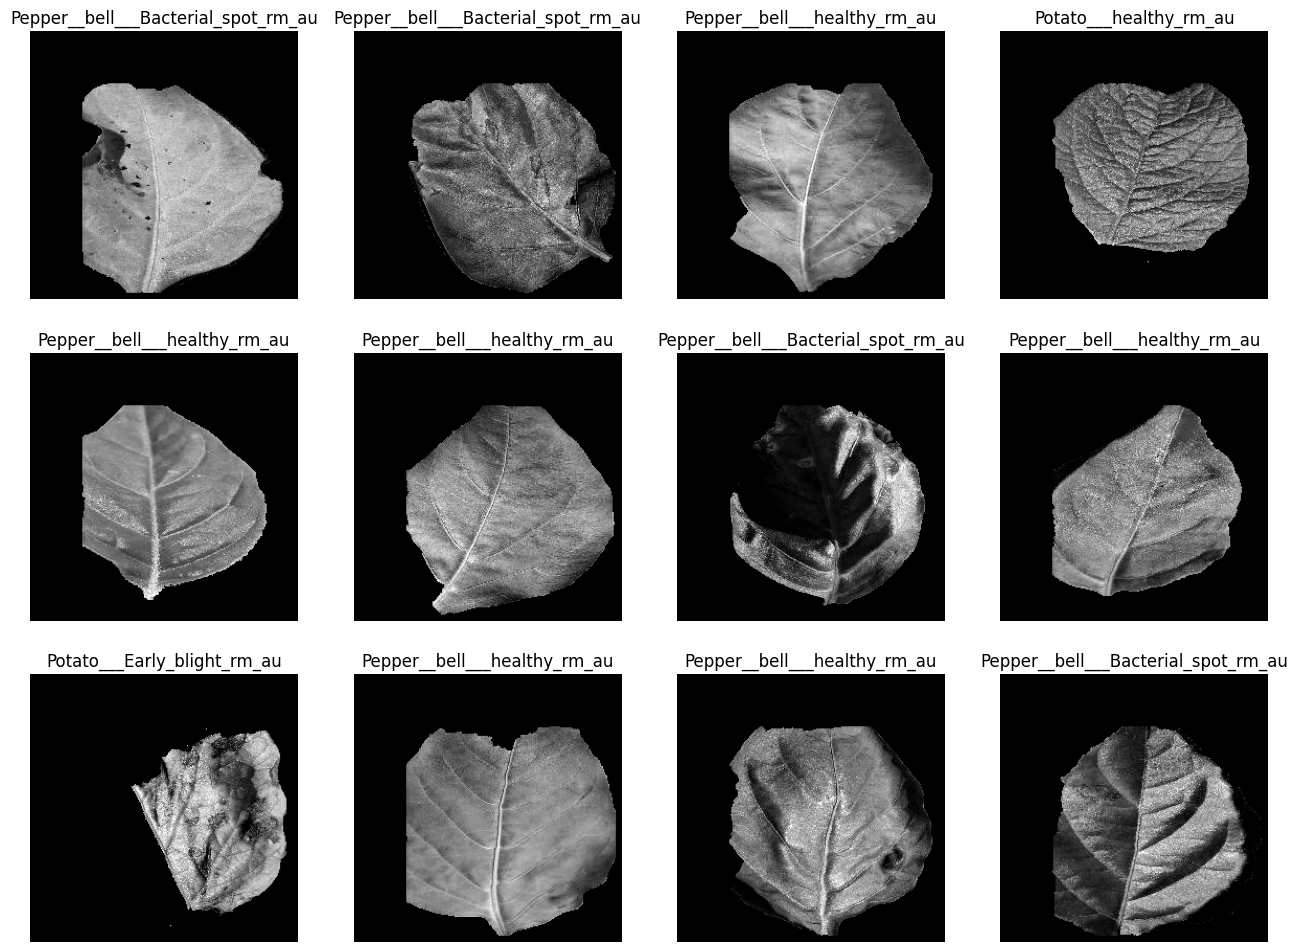

In [66]:
plt.figure(figsize=(16, 16))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
       

In [67]:
len(dataset)


116

In [68]:
# Split Dataset
# Training: will be used while training => 80%
# Validation: tested against while training => 10%
# Test: tested against after we trained a model => 10%


In [69]:
len(dataset)

116

In [70]:
train_size = 0.8
len(dataset)*train_size

92.80000000000001

In [71]:
test_ds = dataset.skip(116)
len(test_ds)

0

In [72]:
val_size=0.1
len(dataset)*val_size

11.600000000000001

In [73]:
val_ds = test_ds.take(14)
len(val_ds)

0

In [74]:
test_ds = test_ds.skip(14)
len(test_ds)

0

In [75]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [76]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [77]:
len(train_ds)

92

In [78]:
len(val_ds)

11

In [79]:
len(test_ds)

13

In [80]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

In [81]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [89]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

# Freeze the pre-trained layers
base_model.trainable = False

# Add a new classification layer
model = tf.keras.Sequential([
     data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer= keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


Epoch 1/10
 7/92 [=>............................] - ETA: 3:54 - loss: 1.2989 - accuracy: 0.5491

KeyboardInterrupt: 

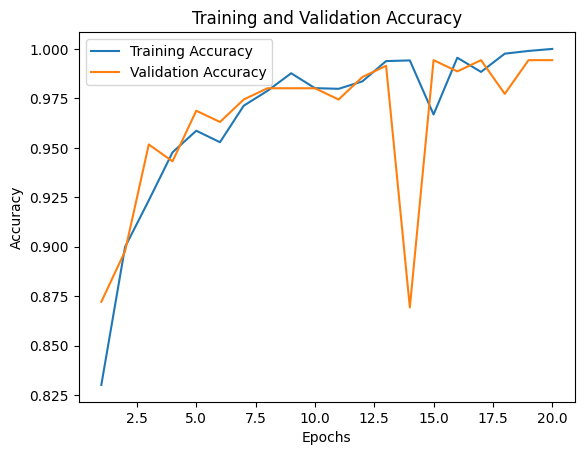

In [83]:

import matplotlib.pyplot as plt


# Get the training accuracy values
train_acc = history.history['accuracy']
# Get the validation accuracy values
val_acc = history.history['val_accuracy']

# Plot the training accuracy and validation accuracy
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

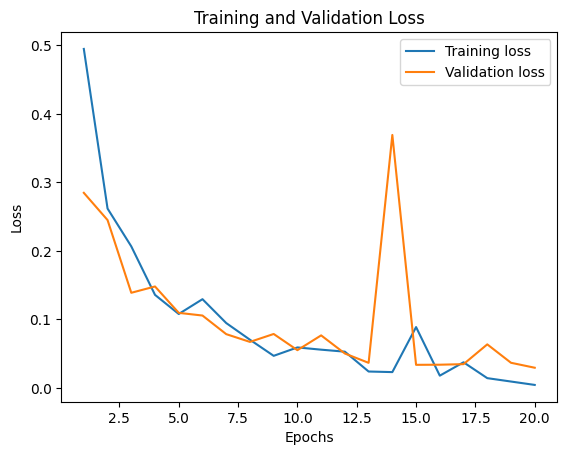

In [84]:
# Get the training loss values
train_loss = history.history['loss']
# Get the validation loss values
validation_loss = history.history['val_loss']

# Plot the training accuracy and validation accuracy
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_loss, label='Training loss')
plt.plot(epochs_range, validation_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 24,113,541
Trainable params: 525,829
Non-trainable params: 23,587,712
_________________________________________________________________


In [32]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       